## Import Libraries

In [40]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np

## Paths

In [11]:
train_path = r"c:\Users\Lenovo\Downloads\Data Set\Data Set\Training"
test_path  = r"c:\Users\Lenovo\Downloads\Data Set\Data Set\Testing"


In [41]:
# Function to get image count per class
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Count images in train and test
train_counts = count_images(train_path)
test_counts = count_images(test_path)

print("Train Image Counts:", train_counts)
print("Test Image Counts:", test_counts)

Train Image Counts: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Test Image Counts: {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


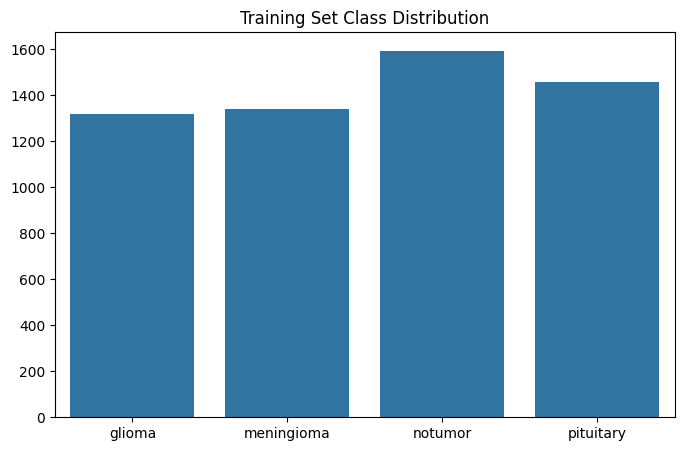

In [42]:
# Plot class distribution
plt.figure(figsize=(8,5))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title("Training Set Class Distribution")
plt.show()

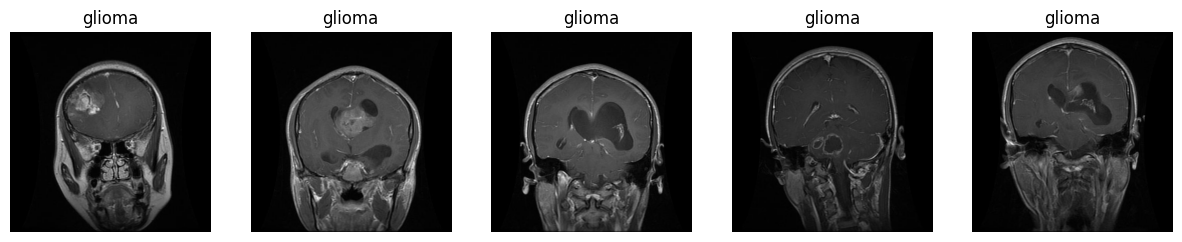

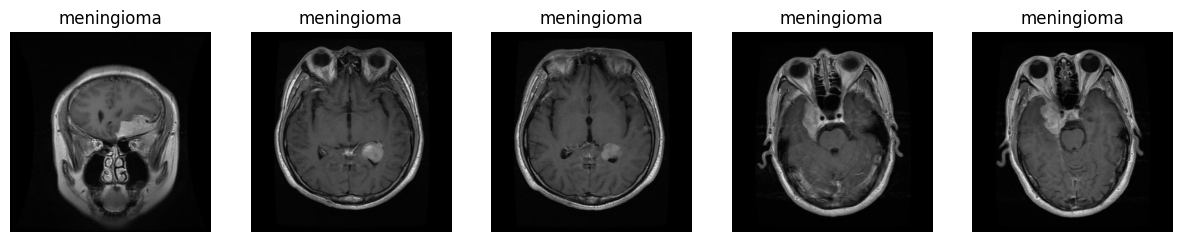

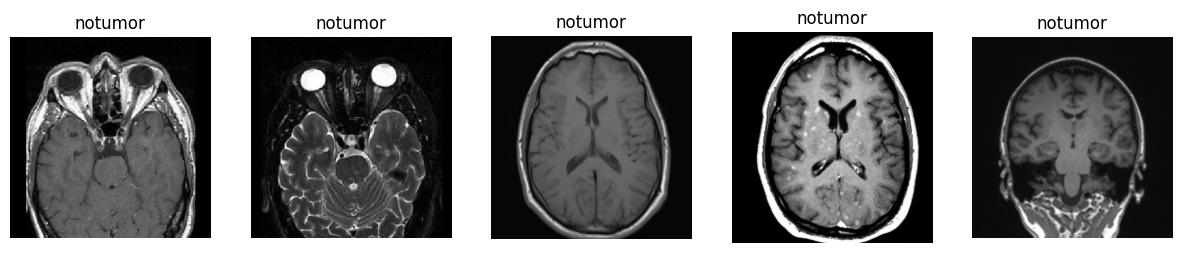

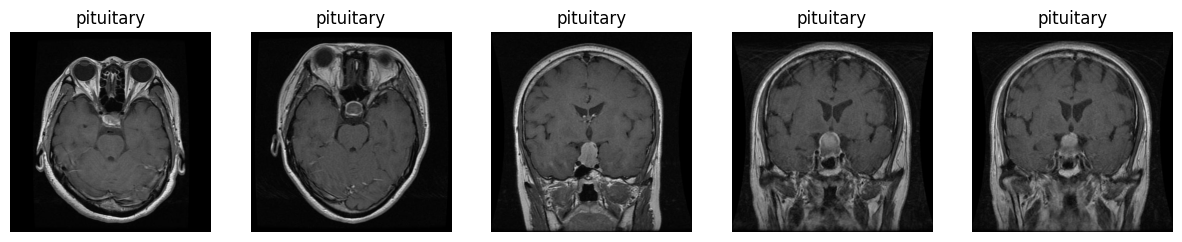

In [45]:
# Visualize some sample images
def show_samples(directory, class_name, n=5):
    class_path = os.path.join(directory, class_name)
    images = os.listdir(class_path)[:n]
    plt.figure(figsize=(15,3))
    for i, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_name)
    plt.show()

# Show samples from each class
for cls in os.listdir(train_path):
    show_samples(train_path, cls, n=5)

In [46]:
# Check image shapes
image_shapes = {}
for cls in os.listdir(train_path):
    cls_path = os.path.join(train_path, cls)
    shapes = []
    for img_file in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_file)
        img = Image.open(img_path)
        shapes.append(np.array(img).shape)
    image_shapes[cls] = shapes

# Print example image shapes per class
for cls, shapes in image_shapes.items():
    print(f"{cls} example shape: {shapes[0]}")

glioma example shape: (512, 512, 3)
meningioma example shape: (512, 512, 3)
notumor example shape: (350, 350, 3)
pituitary example shape: (512, 512, 3)


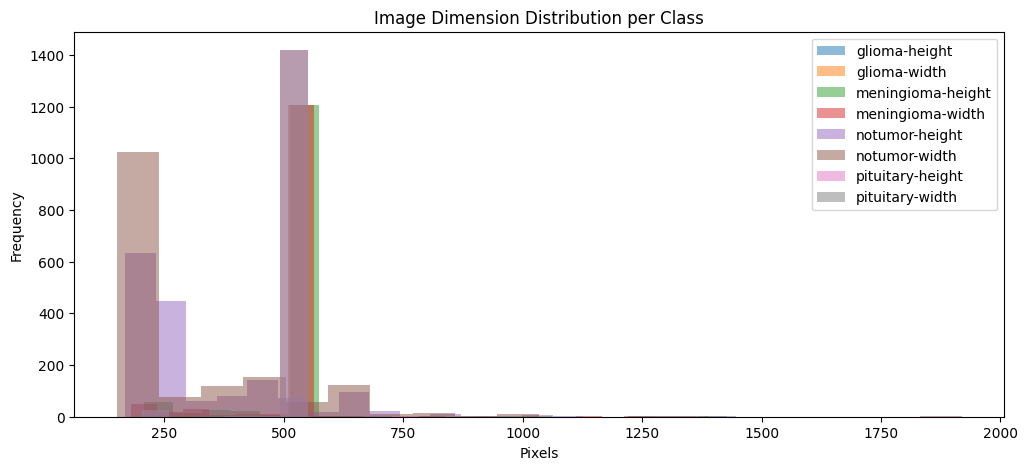

In [47]:
# Plot image size distribution
plt.figure(figsize=(12,5))
for cls, shapes in image_shapes.items():
    heights = [s[0] for s in shapes]
    widths = [s[1] for s in shapes]
    plt.hist(heights, bins=20, alpha=0.5, label=f"{cls}-height")
    plt.hist(widths, bins=20, alpha=0.5, label=f"{cls}-width")
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.title("Image Dimension Distribution per Class")
plt.legend()
plt.show()

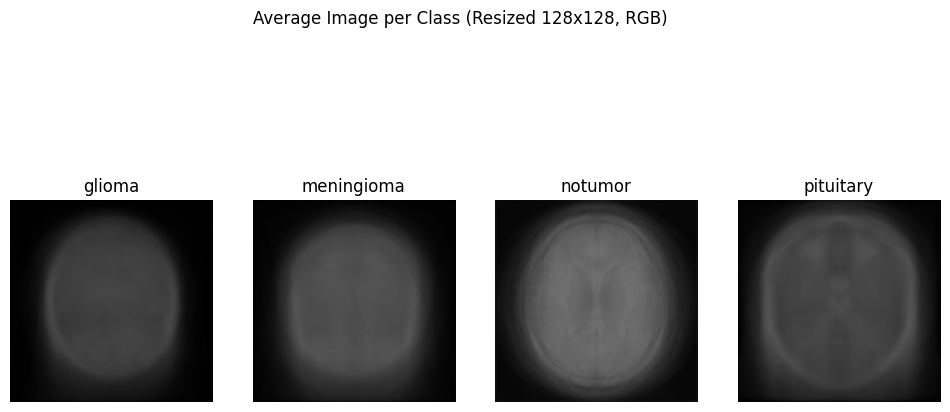

In [51]:
# Compute average image per class (all images converted to RGB)
plt.figure(figsize=(12,6))
for cls in os.listdir(train_path):
    cls_path = os.path.join(train_path, cls)
    imgs = []
    for img_file in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_file)
        # Open image, convert to RGB, resize to 128x128
        img = Image.open(img_path).convert('RGB').resize((128,128))
        imgs.append(np.array(img))
    avg_img = np.mean(imgs, axis=0).astype(np.uint8)
    plt.subplot(1, len(os.listdir(train_path)), list(os.listdir(train_path)).index(cls)+1)
    plt.imshow(avg_img)
    plt.title(cls)
    plt.axis('off')

plt.suptitle("Average Image per Class (Resized 128x128, RGB)")
plt.show()


## Data Generators

In [28]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 16 

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15  # Use 15% of training as validation
)


## Training, Validation and Testing Loader

In [29]:
# Training generator
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Test generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


## CNN Architecture From Scratch

In [30]:
# Lightweight CNN Model
# -------------------------
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    
    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,602,884 (13.74 MB)

 Trainable params: 3,601,924 (13.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [31]:
# Callbacks
# -------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## Training

In [32]:
# Train the Model
# -------------------------
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop]
)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 245s 793ms/step - accuracy: 0.5592 - loss: 2.3036 - val_accuracy: 0.2585 - val_loss: 4.4291
Epoch 2/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 214s 704ms/step - accuracy: 0.6429 - loss: 0.8633 - val_accuracy: 0.6058 - val_loss: 1.1530
Epoch 3/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 221s 728ms/step - accuracy: 0.7194 - loss: 0.7382 - val_accuracy: 0.7170 - val_loss: 0.8516
Epoch 4/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 209s 686ms/step - accuracy: 0.7423 - loss: 0.6626 - val_accuracy: 0.6959 - val_loss: 0.8623
Epoch 5/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 218s 716ms/step - accuracy: 0.7580 - loss: 0.6655 - val_accuracy: 0.7181 - val_loss: 0.8634
Epoch 6/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 214s 702ms/step - accuracy: 0.7667 - loss: 0.6332 - val_accuracy: 0.4819 - val_loss: 1.3313
Epoch 7/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 213s 701ms/step - accuracy: 0.7892 - loss: 0.5547 - val_accuracy: 0.7813 - val_loss: 0.5990
Epoch 8/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 210s 691ms/step - accuracy: 0.7890 -

In [33]:
# Evaluate on Test Data
# -------------------------
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))
print(confusion_matrix(y_true, y_pred_classes))

82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step
              precision    recall  f1-score   support

      glioma       0.94      0.73      0.82       300
  meningioma       0.72      0.60      0.65       306
     notumor       0.83      0.99      0.90       405
   pituitary       0.87      0.99      0.92       300

    accuracy                           0.84      1311
   macro avg       0.84      0.82      0.82      1311
weighted avg       0.84      0.84      0.83      1311

[[219  68   0  13]
 [  9 183  83  31]
 [  3   1 399   2]
 [  1   3   0 296]]


## Plot Accuracy and Loss

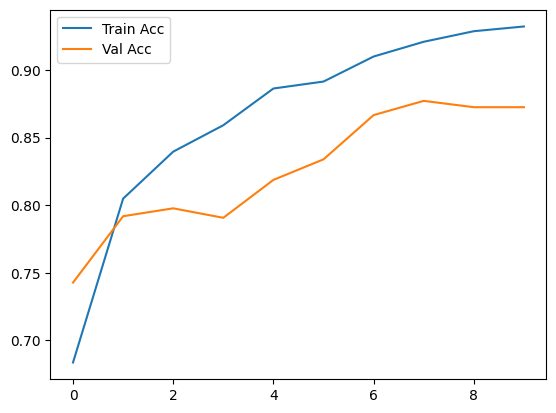

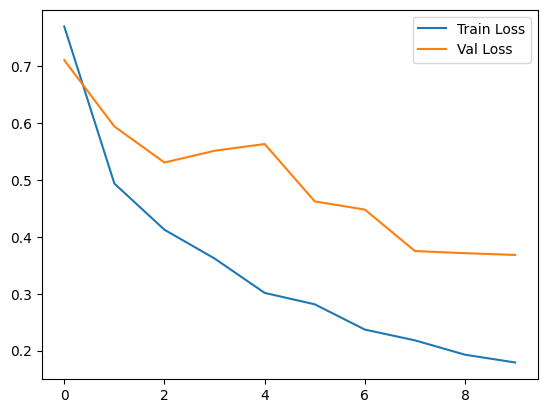

In [ ]:
import matplotlib.pyplot.plt
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()


## Testing

In [16]:
test_loss, test_acc = model.evaluate(test_data)
print("Test Accuracy:", test_acc)


82/82 ━━━━━━━━━━━━━━━━━━━━ 39s 470ms/step - accuracy: 0.8961 - loss: 0.2624
Test Accuracy: 0.8962624073028564


## Save Model

In [17]:
model.save("brain_tumor_cnn_from_scratch.h5")
print("Model Saved!")


Model Saved!


In [37]:
import numpy as np

# Get predictions
pred_probs = model.predict(test_data)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_data.classes

class_labels = list(test_data.class_indices.keys())


82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step


## Classification Report

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_labels))


              precision    recall  f1-score   support

      glioma       0.21      0.19      0.20       300
  meningioma       0.19      0.16      0.18       306
     notumor       0.32      0.35      0.33       405
   pituitary       0.22      0.23      0.22       300

    accuracy                           0.24      1311
   macro avg       0.23      0.23      0.23      1311
weighted avg       0.24      0.24      0.24      1311



## Confusion Matrix & Heatmap

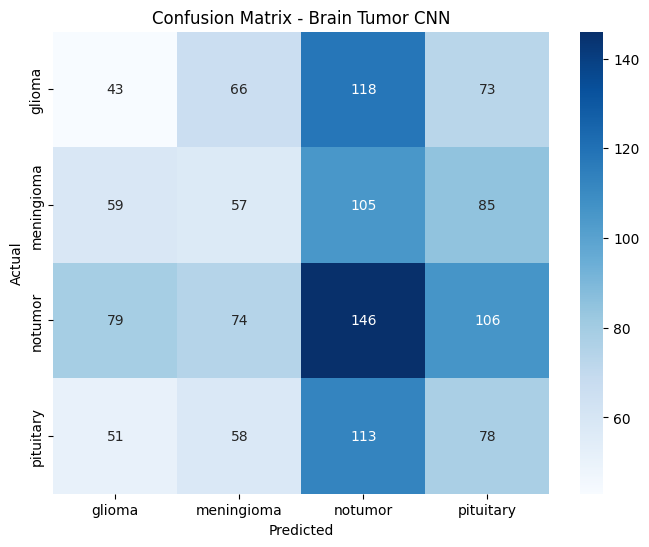

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Brain Tumor CNN")
plt.show()


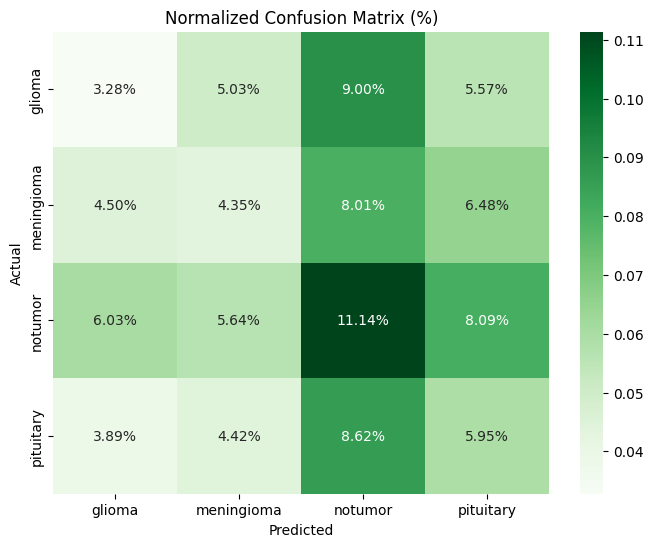

In [39]:
plt.figure(figsize=(8,6))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Greens',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix (%)")
plt.show()
